In [1]:
!pip instal -q -r requirements.txt

ERROR: unknown command "instal" - maybe you meant "install"


In [2]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import prophet

Importing plotly failed. Interactive plots will not work.


# Load data
note that lagged features are generated to avoid leakage

In [3]:
data=pd.read_csv('input/data.csv', index_col=0, parse_dates=[0])
print(data.shape)
data.head()

(427, 12)


,total_purchase_amt,total_redeem_amt,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y,mfd_daily_yield,mfd_7daily_yield
date,,,,,,,,,,,,
2013-07-01,0.165344,0.036072,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125,1.5787,6.307
2013-07-02,0.147781,0.016678,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070,1.5461,6.174
2013-07-03,0.138790,0.038872,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022,1.4670,6.034
2013-07-04,0.093242,0.041854,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000,1.4223,5.903
2013-07-05,0.059284,0.018043,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000,1.3845,5.739


In [4]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['total_purchase_amt']].join(lag1df)
    return df.fillna(0) 
data=process(data)
train=data.iloc[:-30 ] 
test=data.iloc[-30: ] 
print(train.shape, test.shape)


(397, 13) (30, 13)


In [5]:
train.head()

,total_purchase_amt,lag1_total_purchase_amt,lag1_total_redeem_amt,lag1_Interest_O_N,lag1_Interest_1_W,lag1_Interest_2_W,lag1_Interest_1_M,lag1_Interest_3_M,lag1_Interest_6_M,lag1_Interest_9_M,lag1_Interest_1_Y,lag1_mfd_daily_yield,lag1_mfd_7daily_yield
date,,,,,,,,,,,,,
2013-07-01,0.165344,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000
2013-07-02,0.147781,0.165344,0.036072,4.456,5.423,6.040,6.880,5.295,4.2390,4.2820,4.4125,1.5787,6.307
2013-07-03,0.138790,0.147781,0.016678,3.786,4.750,5.074,5.800,5.211,4.2344,4.2808,4.4070,1.5461,6.174
2013-07-04,0.093242,0.138790,0.038872,3.400,4.242,4.658,5.200,5.148,4.2300,4.2796,4.4022,1.4670,6.034
2013-07-05,0.059284,0.093242,0.041854,3.348,3.938,4.464,5.102,5.029,4.2287,4.2776,4.4000,1.4223,5.903


# train

note that using `add_regressor` to add the lag1 feature.

In [6]:
model = prophet.Prophet()
for col in train.columns:
    if col not in ['date', 'total_purchase_amt']:
        model.add_regressor(col)
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'}))

14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:06 - cmdstanpy - INFO - Chain [1] done processing


# results

After incorporating the lag1 feature, the results demonstrate that the model exhibits enhanced predictive capabilities.

In [7]:
train_pred=model.predict(train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,...,lag1_total_redeem_amt,lag1_total_redeem_amt_lower,lag1_total_redeem_amt_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.929765,-0.301438,0.659056,0.929765,0.929765,-0.751154,-0.751154,-0.751154,-1.201593,-1.201593,...,-0.135619,-0.135619,-0.135619,0.450439,0.450439,0.450439,0.0,0.0,0.0,0.178611
2013-07-02,0.930569,0.017664,0.946332,0.930569,0.930569,-0.478471,-0.478471,-0.478471,-0.547179,-0.547179,...,-0.131039,-0.131039,-0.131039,0.068708,0.068708,0.068708,0.0,0.0,0.0,0.452098
2013-07-03,0.931373,-0.082293,0.832146,0.931373,0.931373,-0.557078,-0.557078,-0.557078,-0.584198,-0.584198,...,-0.133502,-0.133502,-0.133502,0.027120,0.027120,0.027120,0.0,0.0,0.0,0.374295
2013-07-04,0.932176,-0.206959,0.699197,0.932176,0.932176,-0.688109,-0.688109,-0.688109,-0.666391,-0.666391,...,-0.130684,-0.130684,-0.130684,-0.021718,-0.021718,-0.021718,0.0,0.0,0.0,0.244067
2013-07-05,0.932980,-0.413023,0.502060,0.932980,0.932980,-0.886569,-0.886569,-0.886569,-0.722558,-0.722558,...,-0.130305,-0.130305,-0.130305,-0.164011,-0.164011,-0.164011,0.0,0.0,0.0,0.046412


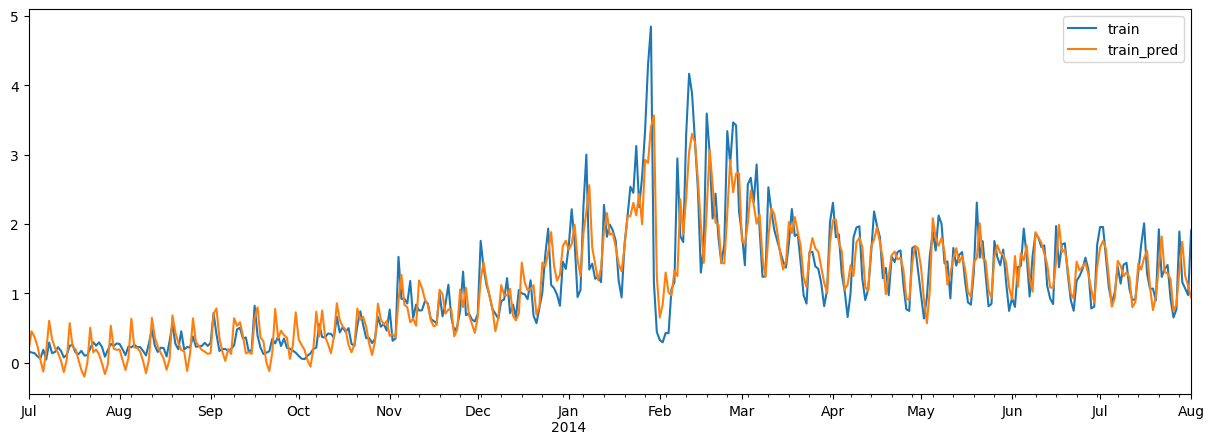

In [8]:
pd.concat([train['total_purchase_amt'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

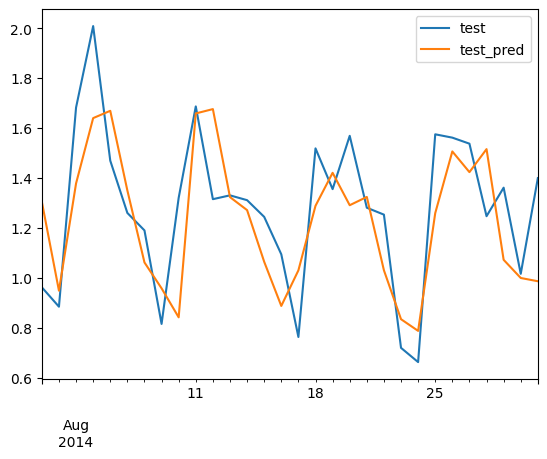

In [9]:
test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([test['total_purchase_amt'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])